In [4]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import MonthEnd, QuarterEnd, QuarterBegin
from dateutil import parser
import time
import seaborn as sns

from numpy.random import randint

In [5]:
conn = wrds.Connection()

Enter your WRDS username [Henry]:hchan1
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [6]:
df=pd.read_csv(r'C:\Users\Henry\OneDrive\Desktop\ACF\AcF351b\acf_351b_python_data.csv')

In [7]:
stmt="""
select cusip_id, trd_exctn_dt, trd_exctn_tm, yld_pt
from trace.trace
where cusip_id in {}
and (trd_exctn_dt between '2015-01-01' and '2017-12-31')
""".format(tuple(df.cusip_id))
df1 = conn.raw_sql(stmt)
df1

,cusip_id,trd_exctn_dt,trd_exctn_tm,yld_pt
0,00077TAA2,2015-01-26,55677.0,NaN
1,00077TAA2,2015-01-26,57718.0,NaN
2,00077TAA2,2015-01-27,49026.0,NaN
3,00077TAA2,2015-03-24,59821.0,NaN
4,00077TAA2,2015-03-26,49847.0,NaN
...,...,...,...,...
1326280,98934KAB6,2017-11-30,62580.0,2.971758
1326281,98934KAB6,2017-12-04,34075.0,3.210928
1326282,98934KAB6,2017-12-04,34075.0,3.009462
1326283,98934KAB6,2017-12-19,44574.0,2.977512


In [8]:
df1['trd_exctn_dt']= pd.to_datetime(df1['trd_exctn_dt'],format='%Y-%m-%d') #change date to datetime dtype

In [9]:
df1 = df1[df1['yld_pt'].notna()] #drop rows with no yields
df1 = df1.sort_values(by=['cusip_id', 'trd_exctn_dt', 'trd_exctn_tm', 'yld_pt'], ascending=True) #sorted by cusip, date,time and yield
df1_ordered = df1
df1_ordered

,cusip_id,trd_exctn_dt,trd_exctn_tm,yld_pt
65,00077TAB0,2015-01-05,52065.0,6.525827
64,00077TAB0,2015-01-05,52065.0,6.608047
67,00077TAB0,2015-01-06,37414.0,6.786439
66,00077TAB0,2015-01-06,37414.0,6.842175
69,00077TAB0,2015-02-17,41055.0,6.897267
...,...,...,...,...
1326280,98934KAB6,2017-11-30,62580.0,2.971758
1326282,98934KAB6,2017-12-04,34075.0,3.009462
1326281,98934KAB6,2017-12-04,34075.0,3.210928
1326283,98934KAB6,2017-12-19,44574.0,2.977512


In [10]:
#Dropped duplicate dates and kept last occurence
df2 = df1_ordered.drop_duplicates(subset=['cusip_id', 'trd_exctn_dt'], keep='last')

In [11]:
df2

,cusip_id,trd_exctn_dt,trd_exctn_tm,yld_pt
64,00077TAB0,2015-01-05,52065.0,6.608047
66,00077TAB0,2015-01-06,37414.0,6.842175
68,00077TAB0,2015-02-17,41055.0,7.002821
72,00077TAB0,2015-03-31,53958.0,6.816467
74,00077TAB0,2015-04-24,43855.0,6.029157
...,...,...,...,...
1326265,98934KAB6,2017-11-22,34069.0,2.936286
1326269,98934KAB6,2017-11-28,29298.0,2.865028
1326280,98934KAB6,2017-11-30,62580.0,2.971758
1326281,98934KAB6,2017-12-04,34075.0,3.210928


In [12]:
#grouped by bond and each month contained sorted yields
Grouped = df2.groupby(['cusip_id',
    pd.Grouper(key=('trd_exctn_dt'),freq='M')])
Grouped = Grouped.apply(lambda _df2: _df2.sort_values(by=['yld_pt'],ascending=True))

In [13]:
Grouped

cusip_id trd_exctn_dt  trd_exctn_tm    yld_pt
cusip_id  trd_exctn_dt                                                        
00077TAB0 2015-01-31   64       00077TAB0   2015-01-05       52065.0  6.608047
                       66       00077TAB0   2015-01-06       37414.0  6.842175
          2015-02-28   68       00077TAB0   2015-02-17       41055.0  7.002821
          2015-03-31   72       00077TAB0   2015-03-31       53958.0  6.816467
          2015-04-30   74       00077TAB0   2015-04-24       43855.0  6.029157
...                                   ...          ...           ...       ...
98934KAB6 2017-11-30   1326265  98934KAB6   2017-11-22       34069.0  2.936286
                       1326280  98934KAB6   2017-11-30       62580.0  2.971758
                       1326263  98934KAB6   2017-11-14       57268.0  3.036031
          2017-12-31   1326284  98934KAB6   2017-12-19       44575.0  2.960962
                       1326281  98934KAB6   2017-12-04       34075.0  3.210928

[113786 rows x 4 columns]

In [14]:
Grouped = Grouped.reset_index(drop=True)

In [15]:
gp = Grouped

In [16]:
#ranked each yield by bond and sorted yield for each month
gp['rank'] = gp.groupby(['cusip_id',
    pd.Grouper(key=('trd_exctn_dt'), freq='m')])['yld_pt'].rank()

In [17]:
gp

,cusip_id,trd_exctn_dt,trd_exctn_tm,yld_pt,rank
0,00077TAB0,2015-01-05,52065.0,6.608047,1.0
1,00077TAB0,2015-01-06,37414.0,6.842175,2.0
2,00077TAB0,2015-02-17,41055.0,7.002821,1.0
3,00077TAB0,2015-03-31,53958.0,6.816467,1.0
4,00077TAB0,2015-04-24,43855.0,6.029157,1.0
...,...,...,...,...,...
113781,98934KAB6,2017-11-22,34069.0,2.936286,2.0
113782,98934KAB6,2017-11-30,62580.0,2.971758,3.0
113783,98934KAB6,2017-11-14,57268.0,3.036031,4.0
113784,98934KAB6,2017-12-19,44575.0,2.960962,1.0


In [18]:
gp2 = gp.groupby(['cusip_id',
    pd.Grouper(key=('trd_exctn_dt'), freq='m')])

In [19]:
gp2

In [20]:
#find median of the ranks for each group
med=gp2['rank'].transform('median') 

In [21]:
#rounds the median to whole number 
med2 = np.ceil(med) 

In [22]:
#selects median observation and removes ranked column
final1a = gp[gp['rank']==med2].drop('rank',axis=1)

In [23]:
#Removed trade execution time
final1a= final1a.drop(columns='trd_exctn_tm')

In [24]:
final1a

,cusip_id,trd_exctn_dt,yld_pt
1,00077TAB0,2015-01-06,6.842175
2,00077TAB0,2015-02-17,7.002821
3,00077TAB0,2015-03-31,6.816467
4,00077TAB0,2015-04-24,6.029157
6,00077TAB0,2015-06-10,6.492385
...,...,...,...
113764,98934KAB6,2017-08-09,2.807131
113771,98934KAB6,2017-09-26,2.858460
113777,98934KAB6,2017-10-24,2.955087
113782,98934KAB6,2017-11-30,2.971758


End of 1a

1b

In [25]:
dfpermnoco=pd.read_csv(r'C:\Users\Henry\OneDrive\Desktop\ACF\AcF351b\permnoco.csv')

In [26]:
stmt1="""
select permno, permco, date, ret
from crsp.dsf
where permco in {}
and (date between '2014-01-01' and '2017-12-31')
""".format(tuple(dfpermnoco.PERMCO))
dfret = conn.raw_sql(stmt1)

In [114]:
dfret1 = dfret.sort_values(by=['permno', 'date'],) #sorted by PERMNO
dfret1

,permno,permco,date,ret
1,10145.0,22168.0,2014-01-02,-0.011492
2,10145.0,22168.0,2014-01-03,0.002214
3,10145.0,22168.0,2014-01-06,-0.000994
4,10145.0,22168.0,2014-01-07,0.004092
5,10145.0,22168.0,2014-01-08,-0.003965
...,...,...,...,...
155577,93013.0,53204.0,2017-12-22,0.001886
155578,93013.0,53204.0,2017-12-26,-0.001345
155579,93013.0,53204.0,2017-12-27,0.006642
155580,93013.0,53204.0,2017-12-28,-0.007936


In [118]:
#Changed data type into appriopriate types
dfret1['date']= pd.to_datetime(dfret1['date'])
dfret1['ret'] = pd.to_numeric(dfret1['ret'], errors='coerce')

In [119]:
dfret1['stdev'] = dfret1.groupby('permno')['ret'].rolling(180).std().reset_index(level=0,drop=True)
dfret1

,permno,permco,date,ret,stdev
1,10145.0,22168.0,2014-01-02,-0.011492,NaN
2,10145.0,22168.0,2014-01-03,0.002214,NaN
3,10145.0,22168.0,2014-01-06,-0.000994,NaN
4,10145.0,22168.0,2014-01-07,0.004092,NaN
5,10145.0,22168.0,2014-01-08,-0.003965,NaN
...,...,...,...,...,...
155577,93013.0,53204.0,2017-12-22,0.001886,0.010455
155578,93013.0,53204.0,2017-12-26,-0.001345,0.010445
155579,93013.0,53204.0,2017-12-27,0.006642,0.010446
155580,93013.0,53204.0,2017-12-28,-0.007936,0.010463


In [120]:
#filtered for selected dates
final1b = dfret1[(dfret1['date'] > '2015-01-01') & (dfret1['date'] < '2017-12-31')]
final1b = final1b.dropna() #dropped empty rows.


In [121]:
final1b

,permno,permco,date,ret,stdev
207,10145.0,22168.0,2015-01-02,0.003103,0.010046
221,10145.0,22168.0,2015-01-05,-0.019056,0.010150
222,10145.0,22168.0,2015-01-06,-0.002339,0.010152
230,10145.0,22168.0,2015-01-07,0.007238,0.010164
231,10145.0,22168.0,2015-01-08,0.018219,0.010237
...,...,...,...,...,...
155577,93013.0,53204.0,2017-12-22,0.001886,0.010455
155578,93013.0,53204.0,2017-12-26,-0.001345,0.010445
155579,93013.0,53204.0,2017-12-27,0.006642,0.010446
155580,93013.0,53204.0,2017-12-28,-0.007936,0.010463


1b trial2

In [26]:
#dfstdev = dfret1.groupby('permno')[['ret']].rolling(180).std()
#dfstdev

In [33]:
#dfstdev = dfret1.groupby('permno')[['ret']].rolling(180).std().reset_index() #calculated 180 day stdev
#dfstdev.drop(columns='level_1', inplace=True)
#dfstdev.rename({'ret':'st_dev'},axis=1, inplace=True)
#dfstdev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155582 entries, 0 to 155581
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   permno  155582 non-null  float64
 1   st_dev  126497 non-null  float64
dtypes: float64(2)
memory usage: 2.4 MB


In [28]:
#left = dfret1

In [29]:
#right = dfstdev

In [30]:
#combined st dev data with permno, permco ret and date data
#data = pd.concat([dfret1, dfstdev], axis=1,)


In [31]:
data

,permno,permco,date,ret,permno,st_dev
0,10145.0,22168.0,2014-08-27,0.000628,10145.0,NaN
1,10145.0,22168.0,2014-12-23,0.007608,10145.0,NaN
2,10145.0,22168.0,2014-12-24,-0.000196,10145.0,NaN
3,10145.0,22168.0,2014-12-26,-0.003237,10145.0,NaN
4,10145.0,22168.0,2014-12-29,0.000394,10145.0,NaN
...,...,...,...,...,...,...
155577,93013.0,53204.0,2016-04-27,-0.000934,93013.0,0.010455
155578,93013.0,53204.0,2016-04-28,-0.007530,93013.0,0.010445
155579,93013.0,53204.0,2016-04-29,-0.007830,93013.0,0.010446
155580,93013.0,53204.0,2016-05-02,0.013368,93013.0,0.010463


In [32]:
data.columns = ['permno', 'permco', 'date', 'ret', 'permno2','st_dev'] #renamed the duplicate permno to permno2 to drop it. 

In [33]:
data1 = data.drop(columns='permno2') #dropped permno2

In [34]:
data1

,permno,permco,date,ret,st_dev
0,10145.0,22168.0,2014-08-27,0.000628,NaN
1,10145.0,22168.0,2014-12-23,0.007608,NaN
2,10145.0,22168.0,2014-12-24,-0.000196,NaN
3,10145.0,22168.0,2014-12-26,-0.003237,NaN
4,10145.0,22168.0,2014-12-29,0.000394,NaN
...,...,...,...,...,...
155577,93013.0,53204.0,2016-04-27,-0.000934,0.010455
155578,93013.0,53204.0,2016-04-28,-0.007530,0.010445
155579,93013.0,53204.0,2016-04-29,-0.007830,0.010446
155580,93013.0,53204.0,2016-05-02,0.013368,0.010463


In [35]:
data1 = data1.sort_values(by=['permno', 'date'],) #sorted by PERMNO and date
data1

,permno,permco,date,ret,st_dev
5,10145.0,22168.0,2014-01-02,-0.011492,NaN
6,10145.0,22168.0,2014-01-03,0.002214,NaN
7,10145.0,22168.0,2014-01-06,-0.000994,NaN
8,10145.0,22168.0,2014-01-07,0.004092,NaN
9,10145.0,22168.0,2014-01-08,-0.003965,NaN
...,...,...,...,...,...
155536,93013.0,53204.0,2017-12-22,0.001886,0.010770
155537,93013.0,53204.0,2017-12-26,-0.001345,0.010795
155538,93013.0,53204.0,2017-12-27,0.006642,0.010799
155539,93013.0,53204.0,2017-12-28,-0.007936,0.010801


In [36]:
#filtered for selected dates
final1b = data1[(data1['date'] > '2015-01-01') & (data1['date'] < '2017-12-31')]
final1b = final1b.dropna() #dropped empty colummns.

In [37]:
final1b

,permno,permco,date,ret,st_dev
196,10145.0,22168.0,2015-01-16,0.011430,0.009338
197,10145.0,22168.0,2015-01-20,0.007738,0.009348
198,10145.0,22168.0,2015-01-21,0.002728,0.009376
199,10145.0,22168.0,2015-01-22,0.001411,0.009301
200,10145.0,22168.0,2015-01-23,0.031291,0.009822
...,...,...,...,...,...
155536,93013.0,53204.0,2017-12-22,0.001886,0.010770
155537,93013.0,53204.0,2017-12-26,-0.001345,0.010795
155538,93013.0,53204.0,2017-12-27,0.006642,0.010799
155539,93013.0,53204.0,2017-12-28,-0.007936,0.010801


1c

In [38]:
dfgv= pd.read_csv(r'C:\Users\Henry\OneDrive\Desktop\ACF\AcF351b\gvkey.csv')

In [122]:
#stmt2="""
#select gvkey, PRCCQ, CSHOQ, DLTTQ, LCTQ, ATQ, datadate
#from comp.fundq
#where gvkey in {}
#and (date between '2015-01-01' and '2017-12-31')
#""".format(tuple(dfgv.GVKEY))
#dfgv = conn.raw_sql(stmt2)

1c downloaded data using compustat file fundq

In [124]:
df1c= pd.read_csv(r'C:\Users\Henry\OneDrive\Desktop\ACF\AcF351b\1c_lev.csv')


In [125]:
df1c = df1c.fillna(0) #filled missing entries with 0 


In [126]:
#book leverage = (DLTTQ + LCTQ) / ATQ
#Market leverage = (DLTTQ + LCTQ) / (PRCCQ * CSHOQ)

In [127]:
df1c['Book_lev'] = (df1c['dlttq'] + df1c['lctq'])/df1c['atq']

In [128]:
df1c['Market_lev'] = (df1c['dlttq'] + df1c['lctq'])/(df1c['prccq'] + df1c['cshoq'])

In [129]:
df1c

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,atq,cshoq,dlttq,lctq,costat,prccq,Book_lev,Market_lev
0,1300,2015-03-31,2015,1,INDL,C,D,STD,USD,2015Q1,2015Q1,45357.000,781.707,5661.000,15432.0,A,104.31,0.465044,23.806541
1,1300,2015-06-30,2015,2,INDL,C,D,STD,USD,2015Q2,2015Q2,46412.000,781.762,5562.000,15574.0,A,101.97,0.455399,23.916753
2,1300,2015-09-30,2015,3,INDL,C,D,STD,USD,2015Q3,2015Q3,46625.000,770.691,5599.000,16367.0,A,94.69,0.471121,25.383039
3,1300,2015-12-31,2015,4,INDL,C,D,STD,USD,2015Q4,2015Q4,49316.000,770.400,5554.000,18371.0,A,103.57,0.485137,27.375082
4,1300,2016-03-31,2016,1,INDL,C,D,STD,USD,2016Q1,2016Q1,50365.000,762.115,9700.000,15659.0,A,112.05,0.503504,29.009398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,252940,2016-12-31,2016,3,INDL,C,D,STD,USD,2016Q4,2016Q3,2586542.894,13429.631,219398.261,0.0,A,6.16,0.084823,16.329389
1852,252940,2017-03-31,2016,4,INDL,C,D,STD,USD,2017Q1,2016Q4,2722353.780,13429.944,241134.298,0.0,A,6.34,0.088576,17.946502
1853,252940,2017-06-30,2017,1,INDL,C,D,STD,USD,2017Q2,2017Q1,0.000,0.000,0.000,0.0,A,6.75,NaN,0.000000
1854,252940,2017-09-30,2017,2,INDL,C,D,STD,USD,2017Q3,2017Q2,2666912.107,13289.784,267516.335,0.0,A,6.44,0.100309,20.119722


1d

In [43]:
dfrating=pd.read_csv(r'C:\Users\Henry\OneDrive\Desktop\ACF\AcF351b\acf351b_ratings.csv') 

In [44]:
dfrating['rating_date']= pd.to_datetime(dfrating['rating_date']) #change date to datetime dtype

In [45]:
dfrating

,issue_id,rating_type,rating_date,rating
0,5,DPR,1993-05-20,NR
1,5,MR,2017-05-24,NR
2,5,FR,2018-12-14,A-
3,5,SPR,2019-05-16,BB+
4,6,DPR,1993-10-13,NR
...,...,...,...,...
3231,834537,FR,2019-06-25,NR
3232,834537,MR,2019-08-01,A3
3233,843393,MR,2019-08-01,Baa3
3234,843393,FR,2019-08-06,NR


Need to sort dfrating before merge

In [46]:
#dup = dfrating[dfrating[['issue_id', 'rating_date']].duplicated() == True]
#dup

In [47]:
#Merged my 1a with the issue id from the python data
dfCI = pd.merge(final1a,df[['cusip_id','issue_id']],on='cusip_id', how='left')
dfCI['issue_id']= dfCI['issue_id'].astype(np.int64) #change issue id to int64 dtype
dfCI = dfCI.sort_values(by=['cusip_id', 'trd_exctn_dt', 'issue_id', 'yld_pt'])

In [48]:
dfCI.sort_values(by=['trd_exctn_dt','issue_id'],ascending=[True, True], inplace=True)
dfrating.sort_values(by=['rating_date', 'issue_id', 'rating'], ascending=[True,True,True], inplace=True)

In [49]:
left = dfCI
right = dfrating

In [50]:
df_1d = pd.merge_asof(left, right, left_on='trd_exctn_dt', right_on='rating_date', by='issue_id', direction='backward')

In [51]:
df_1d

,cusip_id,trd_exctn_dt,yld_pt,issue_id,rating_type,rating_date,rating
0,652482AT7,2015-01-02,4.712971,99272,MR,2008-06-11,Baa1
1,06741JS26,2015-01-02,0.429099,570705,NaN,NaT,NaN
2,50076QAZ9,2015-01-02,2.969970,587727,NaN,NaT,NaN
3,172967HS3,2015-01-02,4.628515,610215,NaN,NaT,NaN
4,172967EW7,2015-01-05,4.407990,500541,NaN,NaT,NaN
...,...,...,...,...,...,...,...
7766,40428HPB2,2017-12-29,2.789291,531627,MR,2017-09-28,A3
7767,172967FT3,2017-12-29,2.785007,563371,SPR,2015-12-02,BBB+
7768,172967GK1,2017-12-29,3.033467,588943,SPR,2015-12-02,BBB
7769,172967KA8,2017-12-29,3.763754,639869,SPR,2015-12-02,BBB


In [52]:
dfCI

,cusip_id,trd_exctn_dt,yld_pt,issue_id
4928,652482AT7,2015-01-02,4.712971,99272
870,06741JS26,2015-01-02,0.429099,570705
4541,50076QAZ9,2015-01-02,2.969970,587727
1834,172967HS3,2015-01-02,4.628515,610215
1229,172967EW7,2015-01-05,4.407990,500541
...,...,...,...,...
3913,40428HPB2,2017-12-29,2.789291,531627
1333,172967FT3,2017-12-29,2.785007,563371
1437,172967GK1,2017-12-29,3.033467,588943
2244,172967KA8,2017-12-29,3.763754,639869


In [1]:
#df_1d.duplicated(subset=['issue_id', 'trd_exctn_dt', 'rating_date'], keep=False)

In [2]:
#df_1d = df_1d.drop_duplicates(subset=['issue_id', 'trd_exctn_dt'], keep=False)

In [3]:
#df_1d = df_1d.drop_duplicates(subset=['issue_id', 'trd_exctn_dt', 'rating_date'], keep=False)

In [60]:
#dup = df_1d.duplicated(subset=['cusip_id', 'trd_exctn_dt'],keep=False)

In [61]:
#df_1d = df_1d[~dup] 

1e

In [130]:
df['maturity']= pd.to_datetime(df['maturity']) #change date to datetime dtype 

In [131]:
df1e = pd.merge(final1a,df[['cusip_id','maturity']],on='cusip_id', how='left')
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity
0,00077TAB0,2015-01-06,6.842175,2093-10-15
1,00077TAB0,2015-02-17,7.002821,2093-10-15
2,00077TAB0,2015-03-31,6.816467,2093-10-15
3,00077TAB0,2015-04-24,6.029157,2093-10-15
4,00077TAB0,2015-06-10,6.492385,2093-10-15
...,...,...,...,...
7766,98934KAB6,2017-08-09,2.807131,2023-11-15
7767,98934KAB6,2017-09-26,2.858460,2023-11-15
7768,98934KAB6,2017-10-24,2.955087,2023-11-15
7769,98934KAB6,2017-11-30,2.971758,2023-11-15


In [132]:
df1e['tm_to_mat_d'] = (df1e['maturity'] - df1e['trd_exctn_dt'])
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_d
0,00077TAB0,2015-01-06,6.842175,2093-10-15,28772 days
1,00077TAB0,2015-02-17,7.002821,2093-10-15,28730 days
2,00077TAB0,2015-03-31,6.816467,2093-10-15,28688 days
3,00077TAB0,2015-04-24,6.029157,2093-10-15,28664 days
4,00077TAB0,2015-06-10,6.492385,2093-10-15,28617 days
...,...,...,...,...,...
7766,98934KAB6,2017-08-09,2.807131,2023-11-15,2289 days
7767,98934KAB6,2017-09-26,2.858460,2023-11-15,2241 days
7768,98934KAB6,2017-10-24,2.955087,2023-11-15,2213 days
7769,98934KAB6,2017-11-30,2.971758,2023-11-15,2176 days


In [133]:
df1e['tm_to_mat_Years'] = df1e.tm_to_mat_d / np.timedelta64(1, 'Y')
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_d,tm_to_mat_Years
0,00077TAB0,2015-01-06,6.842175,2093-10-15,28772 days,78.775060
1,00077TAB0,2015-02-17,7.002821,2093-10-15,28730 days,78.660068
2,00077TAB0,2015-03-31,6.816467,2093-10-15,28688 days,78.545076
3,00077TAB0,2015-04-24,6.029157,2093-10-15,28664 days,78.479366
4,00077TAB0,2015-06-10,6.492385,2093-10-15,28617 days,78.350685
...,...,...,...,...,...,...
7766,98934KAB6,2017-08-09,2.807131,2023-11-15,2289 days,6.267069
7767,98934KAB6,2017-09-26,2.858460,2023-11-15,2241 days,6.135650
7768,98934KAB6,2017-10-24,2.955087,2023-11-15,2213 days,6.058988
7769,98934KAB6,2017-11-30,2.971758,2023-11-15,2176 days,5.957686


In [134]:
func = lambda x: round(x, 2)

In [135]:
df1e['tm_to_mat_Years'] = df1e['tm_to_mat_Years'].map(func)

In [136]:
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_d,tm_to_mat_Years
0,00077TAB0,2015-01-06,6.842175,2093-10-15,28772 days,78.78
1,00077TAB0,2015-02-17,7.002821,2093-10-15,28730 days,78.66
2,00077TAB0,2015-03-31,6.816467,2093-10-15,28688 days,78.55
3,00077TAB0,2015-04-24,6.029157,2093-10-15,28664 days,78.48
4,00077TAB0,2015-06-10,6.492385,2093-10-15,28617 days,78.35
...,...,...,...,...,...,...
7766,98934KAB6,2017-08-09,2.807131,2023-11-15,2289 days,6.27
7767,98934KAB6,2017-09-26,2.858460,2023-11-15,2241 days,6.14
7768,98934KAB6,2017-10-24,2.955087,2023-11-15,2213 days,6.06
7769,98934KAB6,2017-11-30,2.971758,2023-11-15,2176 days,5.96


In [137]:
df1e = df1e.sort_values(by='maturity')

In [138]:
#df1e = df1e.rename(columns={'trd_exctn_dt': 'Date'})
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_d,tm_to_mat_Years
7670,957638AB5,2015-03-20,5.820867,2015-01-09,-70 days,-0.19
7675,957638AB5,2015-08-03,2.671614,2015-01-09,-206 days,-0.56
7674,957638AB5,2015-07-21,8.673810,2015-01-09,-193 days,-0.53
7673,957638AB5,2015-06-30,8.463005,2015-01-09,-172 days,-0.47
7672,957638AB5,2015-05-27,5.444541,2015-01-09,-138 days,-0.38
...,...,...,...,...,...,...
2717,345370BS8,2016-11-15,6.604350,2097-05-15,29401 days,80.50
2722,345370BS8,2017-11-17,5.697198,2097-05-15,29034 days,79.49
2721,345370BS8,2017-09-29,6.171229,2097-05-15,29083 days,79.63
2715,345370BS8,2016-05-24,6.437057,2097-05-15,29576 days,80.98


In [139]:
f = lambda x: 30 if x>=30 else 0 if x<0 else np.ceil(x)

In [140]:
df1e['coupyear']= df1e['tm_to_mat_Years'].map(f)

In [141]:
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_d,tm_to_mat_Years,coupyear
7670,957638AB5,2015-03-20,5.820867,2015-01-09,-70 days,-0.19,0.0
7675,957638AB5,2015-08-03,2.671614,2015-01-09,-206 days,-0.56,0.0
7674,957638AB5,2015-07-21,8.673810,2015-01-09,-193 days,-0.53,0.0
7673,957638AB5,2015-06-30,8.463005,2015-01-09,-172 days,-0.47,0.0
7672,957638AB5,2015-05-27,5.444541,2015-01-09,-138 days,-0.38,0.0
...,...,...,...,...,...,...,...
2717,345370BS8,2016-11-15,6.604350,2097-05-15,29401 days,80.50,30.0
2722,345370BS8,2017-11-17,5.697198,2097-05-15,29034 days,79.49,30.0
2721,345370BS8,2017-09-29,6.171229,2097-05-15,29083 days,79.63,30.0
2715,345370BS8,2016-05-24,6.437057,2097-05-15,29576 days,80.98,30.0


In [142]:
df1e = df1e.drop(columns='tm_to_mat_d')

In [143]:
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear
7670,957638AB5,2015-03-20,5.820867,2015-01-09,-0.19,0.0
7675,957638AB5,2015-08-03,2.671614,2015-01-09,-0.56,0.0
7674,957638AB5,2015-07-21,8.673810,2015-01-09,-0.53,0.0
7673,957638AB5,2015-06-30,8.463005,2015-01-09,-0.47,0.0
7672,957638AB5,2015-05-27,5.444541,2015-01-09,-0.38,0.0
...,...,...,...,...,...,...
2717,345370BS8,2016-11-15,6.604350,2097-05-15,80.50,30.0
2722,345370BS8,2017-11-17,5.697198,2097-05-15,79.49,30.0
2721,345370BS8,2017-09-29,6.171229,2097-05-15,79.63,30.0
2715,345370BS8,2016-05-24,6.437057,2097-05-15,80.98,30.0


In [144]:
dffed =pd.read_csv(r'C:\Users\Henry\OneDrive\Desktop\ACF\AcF351b\data_e.csv')

In [145]:
dffed['Date']= pd.to_datetime(dffed['Date'], dayfirst=True )

In [146]:
dffed

,Date,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,...,SVENF30,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
0,2019-10-25,1.6727,1.6459,1.6344,1.6356,1.6473,1.6675,1.6945,1.7268,1.7632,...,2.7004,1.6258,1.7011,2.1672,5.200000e-07,1.717524,-20.967715,26.143093,11.565900,14.120522
1,2019-10-24,1.6482,1.6110,1.5953,1.5962,1.6098,1.6329,1.6630,1.6982,1.7369,...,2.8117,1.5800,1.6710,2.1569,1.283400e-04,1.712979,-0.029265,7.778353,3.677601,24.990309
2,2019-10-23,1.6433,1.6069,1.5916,1.5925,1.6058,1.6284,1.6580,1.6925,1.7305,...,2.8180,1.5768,1.6658,2.1439,3.687583e-02,1.669800,-0.000128,7.671122,3.624397,25.386636
3,2019-10-22,1.6492,1.6162,1.6026,1.6041,1.6173,1.6396,1.6686,1.7026,1.7401,...,2.8114,1.5896,1.6773,2.1493,1.428800e-04,1.706362,-0.433370,7.788354,4.696139,24.915051
4,2019-10-21,1.6523,1.6210,1.6092,1.6126,1.6279,1.6522,1.6833,1.7192,1.7585,...,2.8199,1.5960,1.6962,2.1847,1.139300e-04,1.708359,-0.489269,7.854000,4.738375,24.336235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2015-01-07,0.2743,0.6592,1.0209,1.3047,1.5161,1.6728,1.7912,1.8835,1.9580,...,3.2082,1.0464,2.3753,2.5994,3.344869e+00,-3.220833,-3.261071,-2.152041,1.076243,7.161798
1203,2015-01-06,0.2766,0.6773,1.0420,1.3256,1.5356,1.6901,1.8058,1.8951,1.9665,...,3.2943,1.0803,2.3895,2.5773,3.514962e+00,-3.454560,-3.189666,-2.627711,1.112406,7.860062
1204,2015-01-05,0.3007,0.7066,1.0898,1.3863,1.6027,1.7595,1.8754,1.9640,2.0346,...,3.4285,1.1150,2.4833,2.6387,3.676113e+00,-3.494336,-3.674921,-2.907890,1.051398,7.899145
1205,2015-01-02,0.2774,0.7027,1.1030,1.4181,1.6519,1.8230,1.9496,2.0458,2.1213,...,3.5701,1.1304,2.6035,2.7567,3.936504e+00,-3.843848,-3.736550,-3.247495,1.129500,8.803059


In [147]:
df1e['coupyear']= df1e['coupyear'].astype(np.int64)

In [148]:
df1e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7771 entries, 7670 to 2720
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cusip_id         7771 non-null   object        
 1   trd_exctn_dt     7771 non-null   datetime64[ns]
 2   yld_pt           7771 non-null   float64       
 3   maturity         7771 non-null   datetime64[ns]
 4   tm_to_mat_Years  7771 non-null   float64       
 5   coupyear         7771 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 425.0+ KB


In [149]:
df1e.sort_values(by='trd_exctn_dt',ascending=True, inplace=True)
dffed.sort_values(by='Date', ascending=True, inplace=True)

In [150]:
df1e

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear
4928,652482AT7,2015-01-02,4.712971,2028-08-04,13.59,14
870,06741JS26,2015-01-02,0.429099,2015-02-23,0.14,1
4541,50076QAZ9,2015-01-02,2.969970,2022-06-06,7.43,8
1834,172967HS3,2015-01-02,4.628515,2044-06-05,29.42,30
1229,172967EW7,2015-01-05,4.407990,2039-07-15,24.52,25
...,...,...,...,...,...,...
3913,40428HPB2,2017-12-29,2.789291,2020-09-27,2.75,3
1333,172967FT3,2017-12-29,2.785007,2022-01-14,4.04,5
3442,38145XAA1,2017-12-29,2.235993,2019-01-31,1.09,2
2244,172967KA8,2017-12-29,3.763754,2027-09-29,9.75,10


In [151]:
dffed

,Date,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,...,SVENF30,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
1206,2014-12-31,0.2940,0.7064,1.1185,1.4471,1.6912,1.8696,2.0014,2.1012,2.1795,...,3.6194,1.1213,2.6853,2.8365,3.973766e+00,-3.742974,-4.175508,-3.137693,1.090554,8.806019
1205,2015-01-02,0.2774,0.7027,1.1030,1.4181,1.6519,1.8230,1.9496,2.0458,2.1213,...,3.5701,1.1304,2.6035,2.7567,3.936504e+00,-3.843848,-3.736550,-3.247495,1.129500,8.803059
1204,2015-01-05,0.3007,0.7066,1.0898,1.3863,1.6027,1.7595,1.8754,1.9640,2.0346,...,3.4285,1.1150,2.4833,2.6387,3.676113e+00,-3.494336,-3.674921,-2.907890,1.051398,7.899145
1203,2015-01-06,0.2766,0.6773,1.0420,1.3256,1.5356,1.6901,1.8058,1.8951,1.9665,...,3.2943,1.0803,2.3895,2.5773,3.514962e+00,-3.454560,-3.189666,-2.627711,1.112406,7.860062
1202,2015-01-07,0.2743,0.6592,1.0209,1.3047,1.5161,1.6728,1.7912,1.8835,1.9580,...,3.2082,1.0464,2.3753,2.5994,3.344869e+00,-3.220833,-3.261071,-2.152041,1.076243,7.161798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2019-10-21,1.6523,1.6210,1.6092,1.6126,1.6279,1.6522,1.6833,1.7192,1.7585,...,2.8199,1.5960,1.6962,2.1847,1.139300e-04,1.708359,-0.489269,7.854000,4.738375,24.336235
3,2019-10-22,1.6492,1.6162,1.6026,1.6041,1.6173,1.6396,1.6686,1.7026,1.7401,...,2.8114,1.5896,1.6773,2.1493,1.428800e-04,1.706362,-0.433370,7.788354,4.696139,24.915051
2,2019-10-23,1.6433,1.6069,1.5916,1.5925,1.6058,1.6284,1.6580,1.6925,1.7305,...,2.8180,1.5768,1.6658,2.1439,3.687583e-02,1.669800,-0.000128,7.671122,3.624397,25.386636
1,2019-10-24,1.6482,1.6110,1.5953,1.5962,1.6098,1.6329,1.6630,1.6982,1.7369,...,2.8117,1.5800,1.6710,2.1569,1.283400e-04,1.712979,-0.029265,7.778353,3.677601,24.990309


In [152]:
left = df1e
right=dffed

In [153]:
dfe_new = pd.merge(left, right, how='left', left_on= 'trd_exctn_dt', right_on='Date')

In [154]:
dfe_new

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear,Date,SVENY01,SVENY02,SVENY03,...,SVENF30,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
0,652482AT7,2015-01-02,4.712971,2028-08-04,13.59,14,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
1,06741JS26,2015-01-02,0.429099,2015-02-23,0.14,1,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
2,50076QAZ9,2015-01-02,2.969970,2022-06-06,7.43,8,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
3,172967HS3,2015-01-02,4.628515,2044-06-05,29.42,30,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
4,172967EW7,2015-01-05,4.407990,2039-07-15,24.52,25,2015-01-05,0.3007,0.7066,1.0898,...,3.4285,1.1150,2.4833,2.6387,3.676113,-3.494336,-3.674921,-2.907890,1.051398,7.899145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7766,40428HPB2,2017-12-29,2.789291,2020-09-27,2.75,3,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7767,172967FT3,2017-12-29,2.785007,2022-01-14,4.04,5,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7768,38145XAA1,2017-12-29,2.235993,2019-01-31,1.09,2,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7769,172967KA8,2017-12-29,3.763754,2027-09-29,9.75,10,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531


In [155]:
dfe_2 = dfe_new

In [156]:
dfe_2

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear,Date,SVENY01,SVENY02,SVENY03,...,SVENF30,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
0,652482AT7,2015-01-02,4.712971,2028-08-04,13.59,14,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
1,06741JS26,2015-01-02,0.429099,2015-02-23,0.14,1,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
2,50076QAZ9,2015-01-02,2.969970,2022-06-06,7.43,8,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
3,172967HS3,2015-01-02,4.628515,2044-06-05,29.42,30,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
4,172967EW7,2015-01-05,4.407990,2039-07-15,24.52,25,2015-01-05,0.3007,0.7066,1.0898,...,3.4285,1.1150,2.4833,2.6387,3.676113,-3.494336,-3.674921,-2.907890,1.051398,7.899145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7766,40428HPB2,2017-12-29,2.789291,2020-09-27,2.75,3,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7767,172967FT3,2017-12-29,2.785007,2022-01-14,4.04,5,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7768,38145XAA1,2017-12-29,2.235993,2019-01-31,1.09,2,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7769,172967KA8,2017-12-29,3.763754,2027-09-29,9.75,10,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531


In [157]:
dfe_2.loc[dfe_2['coupyear'] == 0 ]

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear,Date,SVENY01,SVENY02,SVENY03,...,SVENF30,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
87,957638AB5,2015-01-13,5.044407,2015-01-09,-0.01,0,2015-01-13,0.2182,0.5683,0.9193,...,2.9564,0.9200,2.2603,2.6932,2.958642,-2.670092,-3.396703,-1.632178,0.898074,3.420565
110,65339KAH3,2015-01-16,0.709902,2015-01-09,-0.02,0,2015-01-16,0.2187,0.5120,0.8429,...,2.9544,0.8065,2.1996,2.6161,2.962727,-2.603375,-3.562914,-1.547969,0.994664,4.163694
223,957638AB5,2015-02-04,2.760203,2015-01-09,-0.07,0,2015-02-04,0.2096,0.5423,0.8712,...,2.8743,0.8765,2.1445,2.6115,2.875935,-2.635183,-3.102474,-1.777767,0.901026,3.253350
276,172967FY2,2015-02-10,0.783110,2015-02-03,-0.02,0,2015-02-10,0.2658,0.6949,1.0778,...,3.1466,1.1265,2.3924,2.7261,3.160412,-2.955344,-3.479253,-1.804063,0.864307,4.419135
311,92343VBH6,2015-02-12,0.718289,2015-02-11,-0.00,0,2015-02-12,0.2420,0.6614,1.0441,...,3.1171,1.0831,2.3985,2.7455,3.127543,-2.946883,-3.442811,-1.658651,0.891221,4.276246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7234,369604BC6,2017-10-10,1.455057,2017-06-12,-0.33,0,2017-10-10,1.3779,1.5131,1.6712,...,3.9762,1.6549,2.5146,2.9199,4.766306,-3.439304,-2.664025,-4.776116,1.925980,10.546258
7257,718172BN8,2017-10-12,1.414618,2017-09-11,-0.08,0,2017-10-12,1.3855,1.5251,1.6791,...,3.9535,1.6714,2.4830,2.8798,4.770024,-3.461469,-2.469754,-4.865540,1.999993,10.628813
7382,718172BN8,2017-11-02,1.242365,2017-09-11,-0.14,0,2017-11-02,1.4586,1.6096,1.7581,...,3.8982,1.7679,2.4928,2.8474,4.917772,-3.587547,-2.104086,-5.295047,2.225408,11.517237
7391,369604BC6,2017-11-06,2.653106,2017-06-12,-0.40,0,2017-11-06,1.4771,1.6182,1.7567,...,3.8582,1.7668,2.4435,2.7944,4.783607,-3.427782,-1.970455,-5.062668,2.236653,11.158788


In [158]:
dfe_2 = dfe_2[dfe_2.coupyear != 0]

In [159]:
dfe_2

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear,Date,SVENY01,SVENY02,SVENY03,...,SVENF30,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
0,652482AT7,2015-01-02,4.712971,2028-08-04,13.59,14,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
1,06741JS26,2015-01-02,0.429099,2015-02-23,0.14,1,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
2,50076QAZ9,2015-01-02,2.969970,2022-06-06,7.43,8,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
3,172967HS3,2015-01-02,4.628515,2044-06-05,29.42,30,2015-01-02,0.2774,0.7027,1.1030,...,3.5701,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059
4,172967EW7,2015-01-05,4.407990,2039-07-15,24.52,25,2015-01-05,0.3007,0.7066,1.0898,...,3.4285,1.1150,2.4833,2.6387,3.676113,-3.494336,-3.674921,-2.907890,1.051398,7.899145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7766,40428HPB2,2017-12-29,2.789291,2020-09-27,2.75,3,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7767,172967FT3,2017-12-29,2.785007,2022-01-14,4.04,5,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7768,38145XAA1,2017-12-29,2.235993,2019-01-31,1.09,2,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531
7769,172967KA8,2017-12-29,3.763754,2027-09-29,9.75,10,2017-12-29,1.7573,1.8852,2.0033,...,3.6390,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531


In [160]:
dfe_2.loc[dfe_2['coupyear'] == 0 ]

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear,Date,SVENY01,SVENY02,SVENY03,...,SVENF30,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2


In [161]:
dfe_2['treasury_rate']=[dfe_2.loc[i, 'SVENY'+str(dfe_2.loc[i, 'coupyear']).zfill(2)  ]  for i in dfe_2.index]

<ipython-input-161-27d82adbb319>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe_2['treasury_rate']=[dfe_2.loc[i, 'SVENY'+str(dfe_2.loc[i, 'coupyear']).zfill(2)  ]  for i in dfe_2.index]


In [162]:
dfe_2

,cusip_id,trd_exctn_dt,yld_pt,maturity,tm_to_mat_Years,coupyear,Date,SVENY01,SVENY02,SVENY03,...,SVEN1F01,SVEN1F04,SVEN1F09,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2,treasury_rate
0,652482AT7,2015-01-02,4.712971,2028-08-04,13.59,14,2015-01-02,0.2774,0.7027,1.1030,...,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059,2.3612
1,06741JS26,2015-01-02,0.429099,2015-02-23,0.14,1,2015-01-02,0.2774,0.7027,1.1030,...,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059,0.2774
2,50076QAZ9,2015-01-02,2.969970,2022-06-06,7.43,8,2015-01-02,0.2774,0.7027,1.1030,...,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059,2.0458
3,172967HS3,2015-01-02,4.628515,2044-06-05,29.42,30,2015-01-02,0.2774,0.7027,1.1030,...,1.1304,2.6035,2.7567,3.936504,-3.843848,-3.736550,-3.247495,1.129500,8.803059,2.8373
4,172967EW7,2015-01-05,4.407990,2039-07-15,24.52,25,2015-01-05,0.3007,0.7066,1.0898,...,1.1150,2.4833,2.6387,3.676113,-3.494336,-3.674921,-2.907890,1.051398,7.899145,2.6174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7766,40428HPB2,2017-12-29,2.789291,2020-09-27,2.75,3,2017-12-29,1.7573,1.8852,2.0033,...,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531,2.0033
7767,172967FT3,2017-12-29,2.785007,2022-01-14,4.04,5,2017-12-29,1.7573,1.8852,2.0033,...,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531,2.1912
7768,38145XAA1,2017-12-29,2.235993,2019-01-31,1.09,2,2017-12-29,1.7573,1.8852,2.0033,...,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531,1.8852
7769,172967KA8,2017-12-29,3.763754,2027-09-29,9.75,10,2017-12-29,1.7573,1.8852,2.0033,...,2.0230,2.5496,2.7283,4.832611,-3.198865,-1.664209,-5.516441,2.291842,12.444531,2.4320


In [238]:
#dfe_new['treasury_rate']=[dfe_new.loc[i, 'SVENY'+str(dfe_new.loc[i, 'coupyear']).zfill(2)  ]  for i in dfe_new.index] 

Start of analysis for report

Analysis on bond yield 

Merged final 1a with original data to groupby US and UK bonds

In [193]:
dfcd= pd.merge(final1a,df[['cusip_id','country_domicile','bond_type', 'security_level']],on='cusip_id', how='left')

In [194]:
dfcd

,cusip_id,trd_exctn_dt,yld_pt,country_domicile,bond_type,security_level
0,00077TAB0,2015-01-06,6.842175,USA,CDEB,SUB
1,00077TAB0,2015-02-17,7.002821,USA,CDEB,SUB
2,00077TAB0,2015-03-31,6.816467,USA,CDEB,SUB
3,00077TAB0,2015-04-24,6.029157,USA,CDEB,SUB
4,00077TAB0,2015-06-10,6.492385,USA,CDEB,SUB
...,...,...,...,...,...,...
7766,98934KAB6,2017-08-09,2.807131,USA,CDEB,SEN
7767,98934KAB6,2017-09-26,2.858460,USA,CDEB,SEN
7768,98934KAB6,2017-10-24,2.955087,USA,CDEB,SEN
7769,98934KAB6,2017-11-30,2.971758,USA,CDEB,SEN


In [195]:
cg = dfcd.groupby(['country_domicile',
                   pd.Grouper(key=('trd_exctn_dt'),freq='M')],).mean().reset_index()
cg.rename(columns={'yld_pt':'mean_yld_pt'}, inplace=True)
cg

,country_domicile,trd_exctn_dt,mean_yld_pt
0,GBR,2015-01-31,2.678826
1,GBR,2015-02-28,2.784605
2,GBR,2015-03-31,2.873493
3,GBR,2015-04-30,2.743627
4,GBR,2015-05-31,3.049104
...,...,...,...
67,USA,2017-08-31,3.360805
68,USA,2017-09-30,3.629927
69,USA,2017-10-31,3.854907
70,USA,2017-11-30,4.202113


In [196]:
cg2 = cg.reset_index()

In [197]:
cg2 =cg.set_index('trd_exctn_dt')

Plotted a graph for mean yield for UK and US bonds to see trends

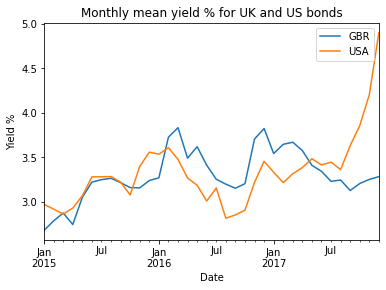

In [198]:
fig1a_1 = cg2.groupby('country_domicile')['mean_yld_pt'].plot(legend=True, xlabel='Date', ylabel='Yield %', title='Monthly mean yield % for UK and US bonds')

In [199]:
cg.sort_values(['country_domicile','trd_exctn_dt'], inplace = True)

cg['mean_yld_pt_ch'] = (cg.groupby('country_domicile')['mean_yld_pt']
                                  .apply(pd.Series.pct_change))

In [200]:
cg

,country_domicile,trd_exctn_dt,mean_yld_pt,mean_yld_pt_ch
0,GBR,2015-01-31,2.678826,NaN
1,GBR,2015-02-28,2.784605,0.039487
2,GBR,2015-03-31,2.873493,0.031921
3,GBR,2015-04-30,2.743627,-0.045195
4,GBR,2015-05-31,3.049104,0.111340
...,...,...,...,...
67,USA,2017-08-31,3.360805,-0.024204
68,USA,2017-09-30,3.629927,0.080077
69,USA,2017-10-31,3.854907,0.061979
70,USA,2017-11-30,4.202113,0.090068


In [201]:
cg3 = cg.set_index('trd_exctn_dt')

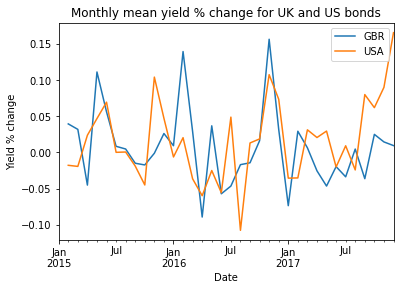

In [203]:
fig1b = cg3.groupby('country_domicile')['mean_yld_pt_ch'].plot(legend=True, xlabel='Date', ylabel='Yield % change', title='Monthly mean yield % change for UK and US bonds')

In [208]:
cg[(cg['trd_exctn_dt'] > '2015-01-01') & (cg['trd_exctn_dt'] < '2016-12-31')]

,country_domicile,trd_exctn_dt,mean_yld_pt,mean_yld_pt_ch
0,GBR,2015-01-31,2.678826,NaN
1,GBR,2015-02-28,2.784605,0.039487
2,GBR,2015-03-31,2.873493,0.031921
3,GBR,2015-04-30,2.743627,-0.045195
4,GBR,2015-05-31,3.049104,0.111340
5,GBR,2015-06-30,3.220462,0.056200
6,GBR,2015-07-31,3.247747,0.008473
7,GBR,2015-08-31,3.263184,0.004753
8,GBR,2015-09-30,3.214393,-0.014952
9,GBR,2015-10-31,3.158776,-0.017303


In [209]:
cg[(cg['trd_exctn_dt'] > '2017-01-01') & (cg['trd_exctn_dt'] < '2017-12-31')]

,country_domicile,trd_exctn_dt,mean_yld_pt,mean_yld_pt_ch
24,GBR,2017-01-31,3.540749,-0.073668
25,GBR,2017-02-28,3.644632,0.029339
26,GBR,2017-03-31,3.668039,0.006422
27,GBR,2017-04-30,3.574666,-0.025456
28,GBR,2017-05-31,3.408278,-0.046546
29,GBR,2017-06-30,3.341453,-0.019607
30,GBR,2017-07-31,3.228689,-0.033747
31,GBR,2017-08-31,3.243785,0.004676
32,GBR,2017-09-30,3.125937,-0.036330
33,GBR,2017-10-31,3.204129,0.025014


Percentage change from Jan 2015 - Feb 2016

In [212]:
((3.72 - 2.68) / 2.68)*100

38.80597014925373

In [213]:
((3.61-2.97) / 2.97)*100

21.548821548821536

Analysis on volatility for UK and US bonds

In [172]:
#Needed to rename columns to merge with different data
dfpermnoco.rename({'CUSIP':'cusip_id', 'PERMNO':'permno', 'PERMCO':'permco'},axis=1, inplace=True)

In [173]:
final1b_2 = final1b.merge(dfpermnoco[['permno','cusip_id']], how='left', left_on='cusip_id', right_on='cusip_id')

KeyError: 'cusip_id'

In [164]:
#Merged 1b with the cusip used to find permco and permno using linking suite in WRDS.
dfcpp = pd.merge(final1b,dfpermnoco[['permno','cusip_id']],on='permno', how='left')

In [165]:
dfcpp

,permno,permco,date,ret,st_dev,cusip_id
0,10145.0,22168.0,2015-01-21,0.002728,0.008654,438516BK1
1,10145.0,22168.0,2015-01-22,0.001411,0.008608,438516BK1
2,10145.0,22168.0,2015-01-23,0.031291,0.008724,438516BK1
3,10145.0,22168.0,2015-01-26,-0.005951,0.008788,438516BK1
4,10145.0,22168.0,2015-01-27,-0.009716,0.008789,438516BK1
...,...,...,...,...,...,...
767503,93013.0,53204.0,2017-12-29,0.002696,0.012271,03523TBK3
767504,93013.0,53204.0,2017-12-29,0.002696,0.012271,035240AC4
767505,93013.0,53204.0,2017-12-29,0.002696,0.012271,035242AF3
767506,93013.0,53204.0,2017-12-29,0.002696,0.012271,035242AK2


As permno and permco had several cusip id's, I had to drop a lot of duplicates. I set it so if a row had the same permno, permco, date and standard deviation, I kept the last occurence. 

In [168]:
dfcpp1 = dfcpp.drop_duplicates(subset=['permno', 'permco', 'date', 'st_dev'],keep='last')

In [169]:
dfcpp1

,permno,permco,date,ret,st_dev,cusip_id
0,10145.0,22168.0,2015-01-21,0.002728,0.008654,438516BK1
1,10145.0,22168.0,2015-01-22,0.001411,0.008608,438516BK1
2,10145.0,22168.0,2015-01-23,0.031291,0.008724,438516BK1
3,10145.0,22168.0,2015-01-26,-0.005951,0.008788,438516BK1
4,10145.0,22168.0,2015-01-27,-0.009716,0.008789,438516BK1
...,...,...,...,...,...,...
767487,93013.0,53204.0,2017-12-22,0.001886,0.011448,03524BAD8
767492,93013.0,53204.0,2017-12-26,-0.001345,0.011457,03524BAD8
767497,93013.0,53204.0,2017-12-27,0.006642,0.012223,03524BAD8
767502,93013.0,53204.0,2017-12-28,-0.007936,0.012238,03524BAD8


In [170]:
final1b

,permno,permco,date,ret,st_dev
179,10145.0,22168.0,2015-01-21,0.002728,0.008654
180,10145.0,22168.0,2015-01-22,0.001411,0.008608
181,10145.0,22168.0,2015-01-23,0.031291,0.008724
182,10145.0,22168.0,2015-01-26,-0.005951,0.008788
183,10145.0,22168.0,2015-01-27,-0.009716,0.008789
...,...,...,...,...,...
155413,93013.0,53204.0,2017-12-22,0.001886,0.011448
155414,93013.0,53204.0,2017-12-26,-0.001345,0.011457
155415,93013.0,53204.0,2017-12-27,0.006642,0.012223
155416,93013.0,53204.0,2017-12-28,-0.007936,0.012238


In [40]:
final1b.loc[final1b['permno'] == 10145 ]

,permno,permco,date,ret,stdev
207,10145.0,22168.0,2015-01-02,0.003103,0.010046
221,10145.0,22168.0,2015-01-05,-0.019056,0.010150
222,10145.0,22168.0,2015-01-06,-0.002339,0.010152
230,10145.0,22168.0,2015-01-07,0.007238,0.010164
231,10145.0,22168.0,2015-01-08,0.018219,0.010237
...,...,...,...,...,...
983,10145.0,22168.0,2017-12-22,-0.001496,0.006667
984,10145.0,22168.0,2017-12-26,0.001759,0.006667
985,10145.0,22168.0,2017-12-27,0.001236,0.006667
986,10145.0,22168.0,2017-12-28,0.001169,0.006601


In [48]:
dfret.loc[dfret['permno'] == 10145].sort_values(by='date')

,permno,permco,date,ret
1,10145.0,22168.0,2014-01-02,-0.011492
2,10145.0,22168.0,2014-01-03,0.002214
3,10145.0,22168.0,2014-01-06,-0.000994
4,10145.0,22168.0,2014-01-07,0.004092
5,10145.0,22168.0,2014-01-08,-0.003965
...,...,...,...,...
983,10145.0,22168.0,2017-12-22,-0.001496
984,10145.0,22168.0,2017-12-26,0.001759
985,10145.0,22168.0,2017-12-27,0.001236
986,10145.0,22168.0,2017-12-28,0.001169


In [155]:
#agroup = final1a.groupby('cusip_id')

In [154]:
#for group in agroup:
    #print (group)